# Topic 1C — Linear Regression + PCA (Boston Housing)

### Script mapping (what this notebook corresponds to)
- `lin_reg_pca_ex3.py` — Linear Regression with PCA on Boston Housing (lecture example)

Dataset:
- `boston-housing.csv`

---

## Learning goals
By the end you should be able to explain:

1. What **Linear Regression** learns and what **R² / MSE** mean.
2. Why **scaling** matters before PCA.
3. How PCA can help with **multicollinearity** (correlated predictors).
4. How to compare **baseline vs PCA** fairly (no leakage; consistent splits).
5. How to pick the number of components (**k**) using explained variance and/or validation.


In [28]:
# Setup
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

def find_file(filename: str) -> Path:
    """Try common locations so the notebook runs in your repo and in this sandbox."""
    candidates = [
        Path(filename),
        Path("..") / "datasets" / "raw" / "Topic1" / filename,
        Path("..") / "datasets" / filename,
        Path("/mnt/data") / filename,  # sandbox
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find {filename}. Tried: {candidates}")

print("Ready ✅")

Ready ✅


## 1) Load the Boston Housing dataset

In this CSV:
- features are the usual Boston predictors
- target column is **`medv`** (median value of owner-occupied homes)

We’ll do:
1) quick inspection
2) separate X (features) and y (target)


In [29]:
path = find_file("boston-housing.csv")
df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()

Shape: (506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [30]:
y = df["medv"]
X = df.drop(columns=["medv"])

print("X shape:", X.shape)
print("y shape:", y.shape)
y.describe()

X shape: (506, 13)
y shape: (506,)


count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

## 2) Why scaling matters (before PCA)

PCA is variance-based. If one feature has larger units, it can dominate variance.
So we use **StandardScaler** to convert each feature into z-scores:

$$
z = \frac{x - \mu}{\sigma}
$$

- $x$ = original feature value
- $\mu$ = mean of that feature
- $\sigma$ = standard deviation of that feature

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Mean (first 5 features):", X_scaled.mean(axis=0)[:5].round(3))
print("Std  (first 5 features):", X_scaled.std(axis=0)[:5].round(3))

Mean (first 5 features): [-0.  0.  0. -0. -0.]
Std  (first 5 features): [1. 1. 1. 1. 1.]


## 3) Linear Regression recap (what it learns)

Linear Regression predicts a continuous target using:

$$
\hat{y} = w^T x + b
$$

It chooses $w$, $b$ to minimize **sum of squared errors**.

### Metrics we’ll use
- **R²** (coefficient of determination): “how much variance of y we explain”
  - 1.0 = perfect, 0 = no better than predicting the mean (can be negative)
- **MSE** (mean squared error): average squared prediction error (lower is better)


## 4) Baseline: Linear Regression WITHOUT PCA

We first fit a baseline on the **scaled original features** (no PCA), using a fixed train/test split.

Why scale here too?  
Scaling doesn’t change ordinary least squares predictions in theory when an intercept is included,
but it helps keep the workflow consistent with PCA and is useful for many other models.


In [32]:
X_train0, X_test0, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=1
)

lr0 = LinearRegression()
lr0.fit(X_train0, y_train)

y_train_pred0 = lr0.predict(X_train0)
y_test_pred0  = lr0.predict(X_test0)

train_r2_0 = lr0.score(X_train0, y_train)
test_r2_0  = lr0.score(X_test0, y_test)

train_mse_0 = mean_squared_error(y_train, y_train_pred0)
test_mse_0  = mean_squared_error(y_test, y_test_pred0)

print("Baseline (no PCA)")
print("  Train R^2:", round(train_r2_0, 4), "| Train MSE:", round(train_mse_0, 4))
print("  Test  R^2:", round(test_r2_0, 4),  "| Test  MSE:", round(test_mse_0, 4))

Baseline (no PCA)
  Train R^2: 0.7104 | Train MSE: 23.5133
  Test  R^2: 0.7836 | Test  MSE: 19.8313


## 5) PCA: how many components should we keep?

We fit PCA on the scaled feature matrix to inspect explained variance.

- **Cumulative explained variance** helps answer: “how many PCs to keep to preserve X% of variance?”
- Lecture script uses **k = 6** (we will reproduce that too)


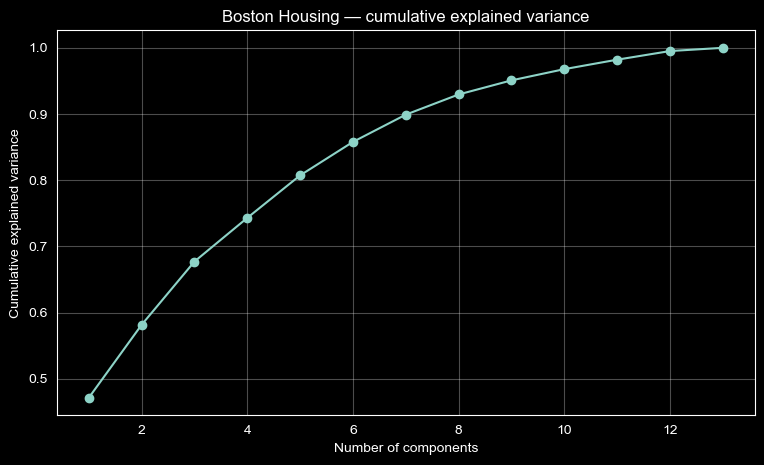

Components for ≥90% variance: 8
Components for ≥95% variance: 9


In [33]:
pca_all = PCA()
pca_all.fit(X_scaled)

explained = pca_all.explained_variance_ratio_
cumulative = np.cumsum(explained)

plt.figure(figsize=(9, 5))
plt.plot(range(1, len(cumulative)+1), cumulative, marker="o")
plt.title("Boston Housing — cumulative explained variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True, alpha=0.3)
plt.show()

k90 = np.argmax(cumulative >= 0.90) + 1
k95 = np.argmax(cumulative >= 0.95) + 1
print("Components for ≥90% variance:", k90)
print("Components for ≥95% variance:", k95)

## 6) Linear Regression WITH PCA (k = 6) - lecture replication

Now we:
1) PCA transform X into 6 components
2) train/test split (same random_state)
3) fit linear regression on the PCA space

Important concept:
- PCA creates **uncorrelated** components → this can stabilize regression when predictors are correlated.
- But PCA can also drop signal useful for predicting y (because PCA is unsupervised).


In [34]:
k = 6
pca6 = PCA(n_components=k)
X_pca6 = pca6.fit_transform(X_scaled)

print("Explained variance kept (k=6):", round(pca6.explained_variance_ratio_.sum(), 4))
print("Reduced shape:", X_pca6.shape)

Explained variance kept (k=6): 0.8579
Reduced shape: (506, 6)


In [35]:
X_train, X_test, y_train2, y_test2 = train_test_split(
    X_pca6, y, test_size=0.30, random_state=1
)

lr = LinearRegression()
lr.fit(X_train, y_train2)

y_train_pred = lr.predict(X_train)
y_test_pred  = lr.predict(X_test)

train_r2 = lr.score(X_train, y_train2)
test_r2  = lr.score(X_test, y_test2)

train_mse = mean_squared_error(y_train2, y_train_pred)
test_mse  = mean_squared_error(y_test2, y_test_pred)

print("With PCA (k=6)")
print("  Train R^2:", round(train_r2, 4), "| Train MSE:", round(train_mse, 4))
print("  Test  R^2:", round(test_r2, 4),  "| Test  MSE:", round(test_mse, 4))

With PCA (k=6)
  Train R^2: 0.6541 | Train MSE: 28.0822
  Test  R^2: 0.7853 | Test  MSE: 19.6758


## 7) Side-by-side comparison (baseline vs PCA)

This cell prints the comparison in one place so you can interpret it quickly.


In [36]:
print("=== Comparison (same train/test split) ===")
print("Baseline (no PCA):")
print("  Test  R^2:", round(test_r2_0, 4), "| Test  MSE:", round(test_mse_0, 4))
print("With PCA (k=6):")
print("  Test  R^2:", round(test_r2, 4),  "| Test  MSE:", round(test_mse, 4))

delta_r2 = test_r2 - test_r2_0
delta_mse = test_mse - test_mse_0
print("\nDelta (PCA - baseline):")
print("  ΔR^2 :", round(delta_r2, 4))
print("  ΔMSE :", round(delta_mse, 4))

=== Comparison (same train/test split) ===
Baseline (no PCA):
  Test  R^2: 0.7836 | Test  MSE: 19.8313
With PCA (k=6):
  Test  R^2: 0.7853 | Test  MSE: 19.6758

Delta (PCA - baseline):
  ΔR^2 : 0.0017
  ΔMSE : -0.1556


## 8) Fairer comparison with cross-validation (optional but recommended)

A single train/test split can be noisy.
Here we compare **baseline vs PCA** using the same CV folds with pipelines.

We evaluate with:
- **R²** (`scoring="r2"`)
- **Negative MSE** (`scoring="neg_mean_squared_error"`)  
  (scikit-learn uses negative because it expects “higher is better”)

This is optional, but it gives a more stable conclusion.


In [37]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

pipe_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipe_pca6 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("model", LinearRegression())
])

r2_base = cross_val_score(pipe_baseline, X, y, cv=cv, scoring="r2")
r2_pca  = cross_val_score(pipe_pca6, X, y, cv=cv, scoring="r2")

mse_base = -cross_val_score(pipe_baseline, X, y, cv=cv, scoring="neg_mean_squared_error")
mse_pca  = -cross_val_score(pipe_pca6, X, y, cv=cv, scoring="neg_mean_squared_error")

print("CV R^2 (baseline):", round(r2_base.mean(), 4), "±", round(r2_base.std(), 4))
print("CV R^2 (PCA k=6):", round(r2_pca.mean(), 4),  "±", round(r2_pca.std(), 4))

print("\nCV MSE (baseline):", round(mse_base.mean(), 4), "±", round(mse_base.std(), 4))
print("CV MSE (PCA k=6):", round(mse_pca.mean(), 4),  "±", round(mse_pca.std(), 4))

CV R^2 (baseline): 0.719 ± 0.1189
CV R^2 (PCA k=6): 0.6931 ± 0.1577

CV MSE (baseline): 23.7591 ± 12.1301
CV MSE (PCA k=6): 26.1779 ± 15.6733


---

### ✅ Interpretation of results (Baseline Linear Regression vs PCA + Linear Regression)

#### 1) Scaling sanity check
- Mean of scaled features ≈ 0 and std ≈ 1
✅ This confirms `StandardScaler` worked correctly and PCA is being applied on comparable feature scales.

---

#### 2) Explained variance (how much information PCA keeps)
From the cumulative explained variance plot:
- **Components for ≥90% variance:** 8
- **Components for ≥95% variance:** 9

For the lecture replication with **k = 6**:
- **Explained variance kept:** 0.8579 (≈ 85.79%)

✅ Interpretation: using 6 PCs is a moderate compression choice — it drops ~14% of variance compared to the full feature space.

---

#### 3) Single train/test split comparison (same split for fairness)

**Baseline (no PCA)**
- Train R² = 0.7104 | Train MSE = 23.5133
- Test  R² = 0.7836 | Test  MSE = 19.8313

**With PCA (k = 6)**
- Train R² = 0.6541 | Train MSE = 28.0822
- Test  R² = 0.7853 | Test  MSE = 19.6758

**Delta (PCA − baseline)**
- ΔR²  = +0.0017
- ΔMSE = −0.1556

✅ Interpretation:
- On this one split, PCA(6) gives a **tiny improvement on test** (slightly higher R² and slightly lower MSE).
- But PCA(6) clearly reduces training performance → the model fits the training data less closely (expected when you reduce dimensions).

Key point:
> PCA acts like a constraint/compression step: it may reduce overfitting slightly, but it can also remove useful predictive signal.

---

#### 4) Cross-validation comparison (more reliable than one split)

**CV R²**
- Baseline: **0.7190 ± 0.1189**
- PCA (k=6): **0.6931 ± 0.1577**

**CV MSE**
- Baseline: **23.7591 ± 12.1301**
- PCA (k=6): **26.1779 ± 15.6733**

✅ Interpretation (important):
- Across many folds, **baseline performs better on average** (higher R², lower MSE).
- PCA(k=6) also shows **higher variability** (larger std), suggesting less stable performance across splits.

So the small improvement seen in the single split is likely **not robust**.

---

#### 5) What should we conclude?

- **Best overall choice here:** baseline Linear Regression (no PCA) performs better in CV.
- PCA with **k=6** is probably **too aggressive**, since:
  - 6 PCs keep ~86% variance, but prediction may depend on some lower-variance directions.
  - PCA is **unsupervised** → it preserves variance, not “predictiveness.”

Practical takeaway:
> If you want PCA for regression, choose k using validation (or try k≈8–9 here since that aligns with 90–95% variance).

---

#### Exam-ready summary (2 lines)
- Single split: PCA(6) ≈ baseline (tiny test improvement).
- Cross-validation: **baseline wins** → PCA(6) slightly harms general performance and increases variability.